In [ ]:
!pip install ann_visualizer

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import numpy
import pandas
import matplotlib
import seaborn
import tensorflow
import keras

In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)
import matplotlib.pyplot as plt
plt.rcdefaults()
from pylab import rcParams
import seaborn as sns
%matplotlib inline

####### Deep learning libraries
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from ann_visualizer.visualize import ann_viz
# 
from sklearn.preprocessing import  StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, roc_auc_score, auc,
                             precision_score, recall_score, roc_curve, precision_recall_curve,
                             precision_recall_fscore_support, f1_score,
                             precision_recall_fscore_support)
#
from IPython.display import display, Math, Latex


# Load Data

In [ ]:
sl = pd.read_csv('./system_logs.csv')

In [ ]:
sl[sl['Label']==1].head()

,Timestamp [ms],\tCPU cores,\tCPU capacity provisioned [MHZ],\tCPU usage [MHZ],\tCPU usage [%],\tMemory capacity provisioned [KB],\tMemory usage [KB],\tDisk read throughput [KB/s],\tDisk write throughput [KB/s],\tNetwork received throughput [KB/s],\tNetwork transmitted throughput [KB/s],Label
276,1376397652,4,11703.99824,11075.883668,94.633333,67108864.0,7.739887e+06,0.000000,6329.133333,0.0,1.400000,1
290,1376401853,4,11703.99824,11073.933001,94.616667,67108864.0,1.530082e+07,0.066667,8233.200000,0.0,1.533333,1
294,1376403053,4,11703.99824,11085.637000,94.716667,67108864.0,2.478554e+07,0.066667,8676.200000,5.4,1.600000,1
314,1376409054,4,11703.99824,11068.081002,94.566667,67108864.0,5.234490e+06,0.200000,8219.800000,0.0,1.533333,1
343,1376417755,4,11703.99824,11073.933001,94.616667,67108864.0,7.471451e+06,0.133333,9396.933333,0.0,1.533333,1


In [ ]:
df1 = sl[['\tCPU usage [%]', '\tMemory usage [KB]', 'Label']]

In [ ]:
df1.columns = ['cpu_usage', 'memory_usage[kb]', 'label']

In [ ]:
df1.shape

(8634, 3)

Text(0.5, 1.0, 'Data per Label')

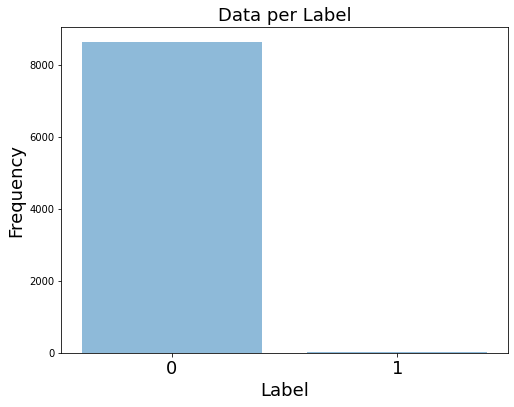

In [ ]:
plt.figure(figsize=(8,6))
objects = tuple(['0', '1']) 
y_pos = np.arange(len(objects))
x   = np.arange(len(objects))
y   = df1.label.value_counts().tolist()
plt.bar(x, y, align='center', alpha=0.5)
plt.xticks(y_pos, objects,fontsize=18)
plt.xlabel('Label', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.title('Data per Label',fontsize=18)


# Data Preprocessing

In [ ]:
RANDOM_SEED = 200
X_train, X_test = train_test_split(df1, test_size=0.2, random_state = RANDOM_SEED)
X_train = X_train[X_train['label'] == 0]
X_train = X_train.drop(['label'], axis=1)
y_test  = X_test['label']
X_test  = X_test.drop(['label'], axis=1)
X_train = X_train.values
X_test  = X_test.values
print('Training data size   :', X_train.shape)
print('Validation data size :', X_test.shape)

Training data size   : (6900, 2)
Validation data size : (1727, 2)


# Data Scaling

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Modeling

In [ ]:
input_dim = X_train.shape[1]
encoding_dim = 6

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh",activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="tanh")(encoder)
encoder = Dense(int(encoding_dim / 4), activation="tanh")(encoder)
decoder = Dense(int(encoding_dim/ 2), activation='tanh')(encoder)
decoder = Dense(int(encoding_dim), activation='tanh')(decoder)
decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_30 (Dense)             (None, 6)                 18        
_________________________________________________________________
dense_31 (Dense)             (None, 3)                 21        
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 4         
_________________________________________________________________
dense_33 (Dense)             (None, 3)                 6         
_________________________________________________________________
dense_34 (Dense)             (None, 6)                 24        
_________________________________________________________________
dense_35 (Dense)             (None, 2)                 14  

In [ ]:
nb_epoch = 100
batch_size = 50
autoencoder.compile(optimizer='adam', loss='mse' )

history = autoencoder.fit(X_train_scaled, X_train_scaled,
                        epochs=nb_epoch,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split=0.1,
                        verbose=0
                        ).history

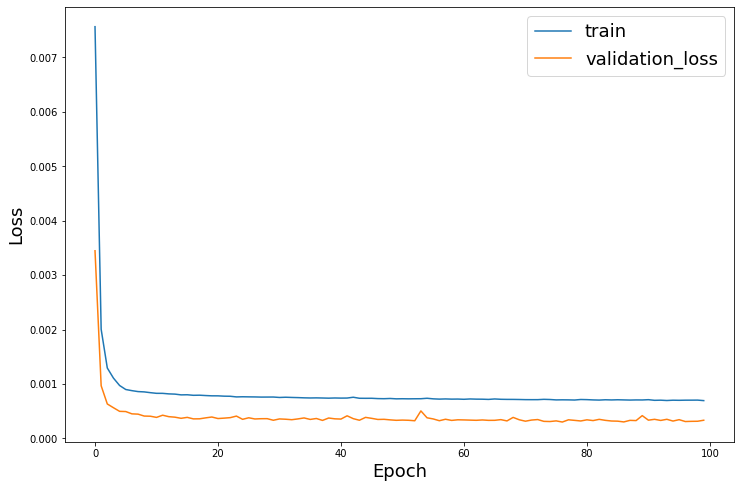

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.ylabel('Loss',fontsize= 18)
plt.xlabel('Epoch',fontsize= 18)
plt.legend(['train', 'validation_loss'], loc='upper right', fontsize= 18);

# Predictions & Reconstruction Error

In [ ]:
predictions = autoencoder.predict(X_test_scaled)

mse = np.mean(np.power(X_test_scaled - predictions, 2), axis=1)
df_error = pd.DataFrame({'reconstruction_error': mse, 'Label': y_test}, index=y_test.index)
df_error.describe()


,reconstruction_error,Label
count,1727.000000,1727.000000
mean,0.000703,0.002316
std,0.006437,0.048085
min,0.000008,0.000000
25%,0.000018,0.000000
50%,0.000018,0.000000
75%,0.000019,0.000000
max,0.163409,1.000000


**Indexes having Reconstruction Error grater than 1.0 are Considered as Anomalies / Outliers**


Text(0.5, 1.0, 'Outlier Score')

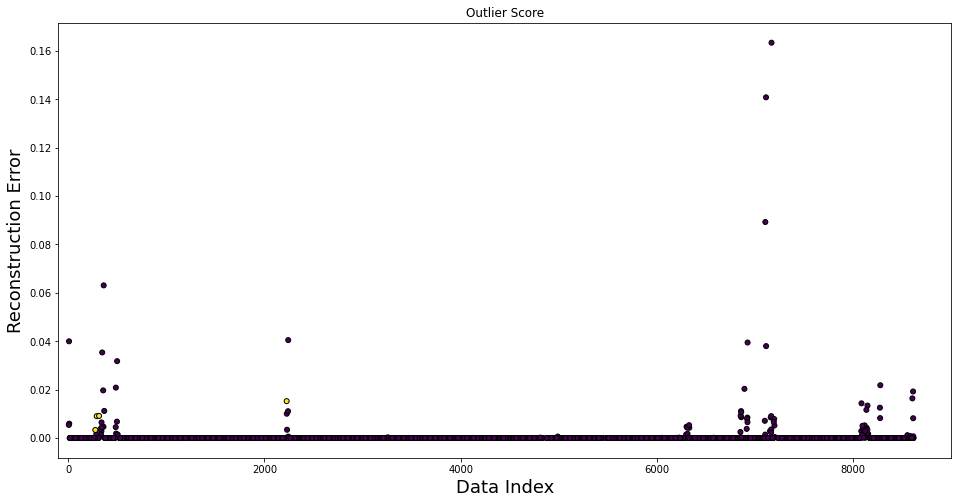

In [ ]:
plt.figure(figsize=(16,8))
plt.scatter(df_error.index, df_error['reconstruction_error'], c=df_error['Label'], edgecolor='black', s=25)
plt.xlabel('Data Index', fontsize = 18)
plt.ylabel('Reconstruction Error', fontsize = 18)
plt.xlim((-100,9000))
plt.title("Outlier Score")


In [ ]:
df_error.sort_values(ascending=False, by = 'reconstruction_error').head(10)

,reconstruction_error,Label
7168,0.163409,0
7112,0.140829,0
7105,0.089279,0
361,0.063100,0
2242,0.040480,0
8,0.039985,0
6924,0.039482,0
7113,0.038002,0
346,0.035375,0
498,0.031786,0


In [ ]:
df1.loc[7168]

cpu_usage           1.216667e+00
memory_usage[kb]    2.080375e+07
label               0.000000e+00
Name: 7168, dtype: float64

In [ ]:
outliers = df_error.index[df_error.reconstruction_error > 0.1].tolist()

In [ ]:
outliers

[7168, 7112]